In [1]:
import pandas as pd
import matplotlib.pyplot as plt   # plotting the graphs
import numpy as np                # for math

from datetime import datetime     # to access datetime
from pandas import Series         # to work on series

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib import rcParams
rcParams['figure.figsize'] = [15,6]

import warnings
warnings.filterwarnings('ignore')

In [2]:
ss_data = pd.read_csv(r"C:\Users\gmwin\Desktop\Data Analytics Projects\Super Store Project\Super_Store_phones_subquery.csv")

In [3]:
ss_data.head()

,Order_Date,Year,Total_Month_Sales
0,1/1/2014,2014,3143.290
1,2/1/2014,2014,1608.510
2,3/1/2014,2014,32511.174
3,4/1/2014,2014,9195.434
4,5/1/2014,2014,9599.876


In [4]:
new_df = ss_data.drop('Year', axis='columns')
new_df['Order_Date'] = pd.to_datetime(new_df['Order_Date'])

In [5]:
new_df.set_index('Order_Date', inplace=True)
new_df.head()

,Total_Month_Sales
Order_Date,
2014-01-01,3143.290
2014-02-01,1608.510
2014-03-01,32511.174
2014-04-01,9195.434
2014-05-01,9599.876


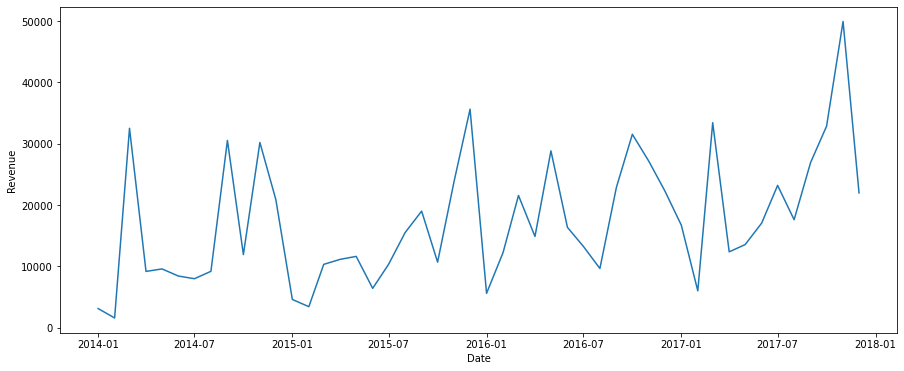

In [6]:
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.plot(new_df)

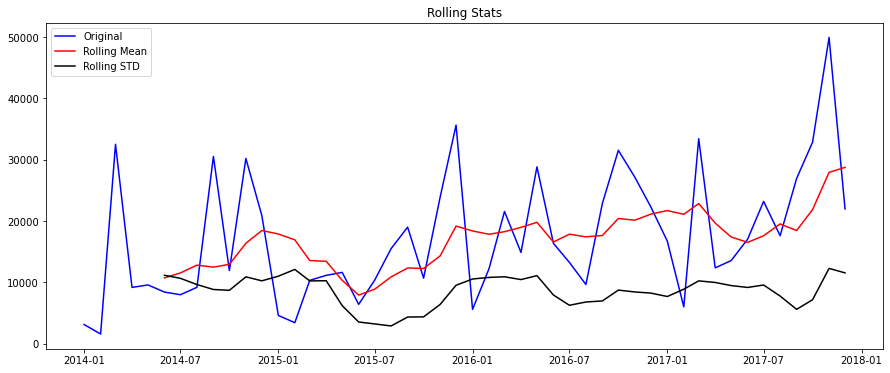

In [7]:
# can already tell you the data is not stationary, but will start will with checking the rolling mean stats and then an ADF test

rolling_mean = new_df.rolling(window=6).mean()
rolling_std = new_df.rolling(window=6).std()

plt.plot(new_df, color='blue', label ='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling STD')
plt.legend(loc='best')
plt.title('Rolling Stats')
plt.show()

In [8]:
# Augmented Dickey-Fuller test also shows the series is not stationary

ADF_result = adfuller(new_df['Total_Month_Sales'])

print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))
print('Critical Values:')
for key, value in ADF_result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistics: -5.522761103726896
p-value: 1.8615967302063814e-06
Critical Values:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064


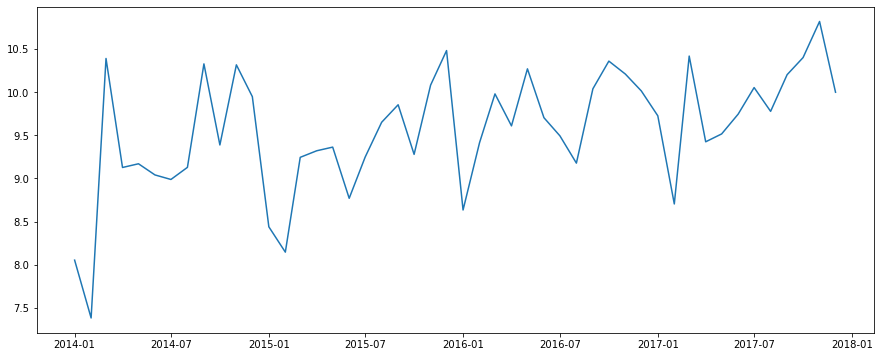

In [9]:
# log of the dependent variable will low rate at which rolling mean increases

df_log = np.log(new_df)
plt.plot(df_log)

In [10]:
# creating a function to test both rolling stats and ADF test

def check_stationarity(series):
    #get rolling stats then plot
    rolling_series_mean = series.rolling(window=6).mean()
    rolling_series_std = series.rolling(window=6).std()
    oringinal = plt.plot(series, label='Original', color='Blue')
    mean = plt.plot(rolling_series_mean, label='Rolling Mean', color='Red')
    std = plt.plot(rolling_series_std, label='Rolling Std', color='Black')
    plt.legend(loc='best')
    plt.title('Rolling Stats')
    plt.show(block=False)
    #add in the ADF test 
    result = adfuller(series['Total_Month_Sales'])
    print('ADF Statistics: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))        

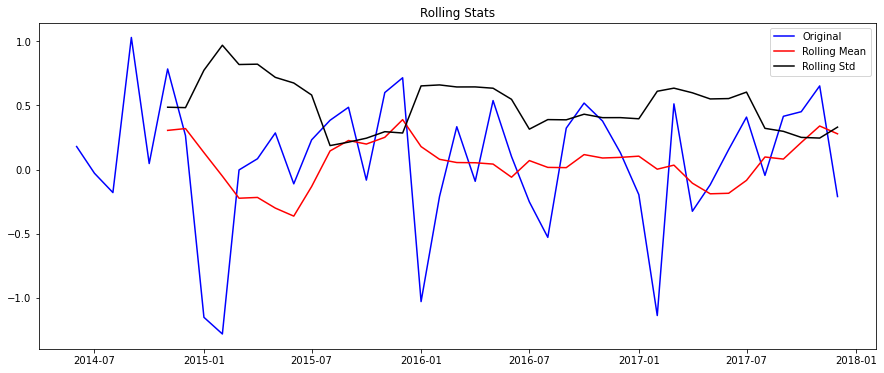

ADF Statistics: -5.644502128747136
p-value: 1.0186402315355622e-06
Critical Values:
	1%: -3.596635636000432
	5%: -2.933297331821618
	10%: -2.6049909750566895


In [11]:
# with the get_stationarity function defined, now need to transform time series to make it stationary and then test
# transform the data by subtracting the rolling mean of our df_log from the df_log
rolling_mean = df_log.rolling(window=6).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)

check_stationarity(df_log_minus_mean)

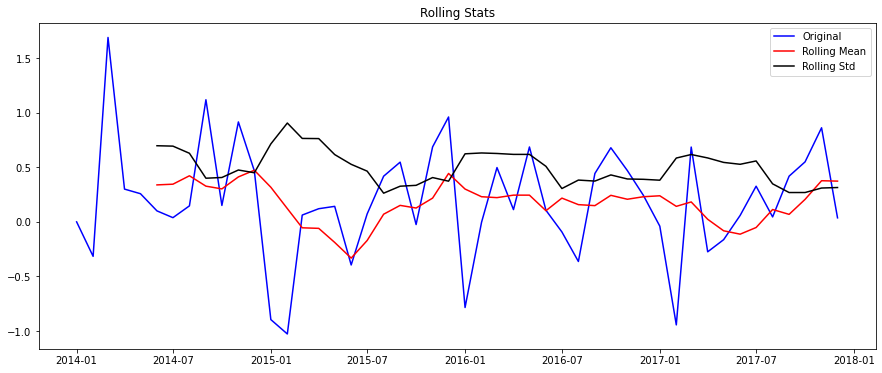

ADF Statistics: -5.256489929538128
p-value: 6.734161162317412e-06
Critical Values:
	1%: -3.5812576580093696
	5%: -2.9267849124681518
	10%: -2.6015409829867675


In [14]:
# going to try exponential decay to make series stationary
rolling_mean_exp_decay = df_log.ewm(halflife=6, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)

check_stationarity(df_log_exp_decay)

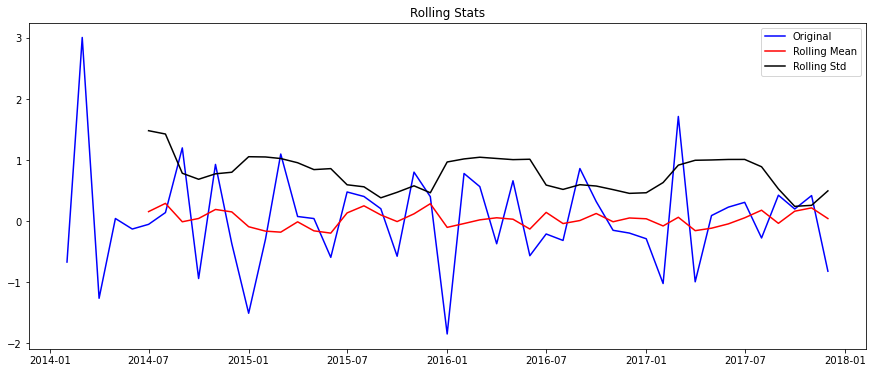

ADF Statistics: -5.289967465033817
p-value: 5.743843107528736e-06
Critical Values:
	1%: -3.626651907578875
	5%: -2.9459512825788754
	10%: -2.6116707716049383


In [15]:
#yikes! that was even less stationary, going to try applying time shift

df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)

check_stationarity(df_log_shift)

In [16]:
# trying the take difference method 

df_diff = new_df.diff().dropna()

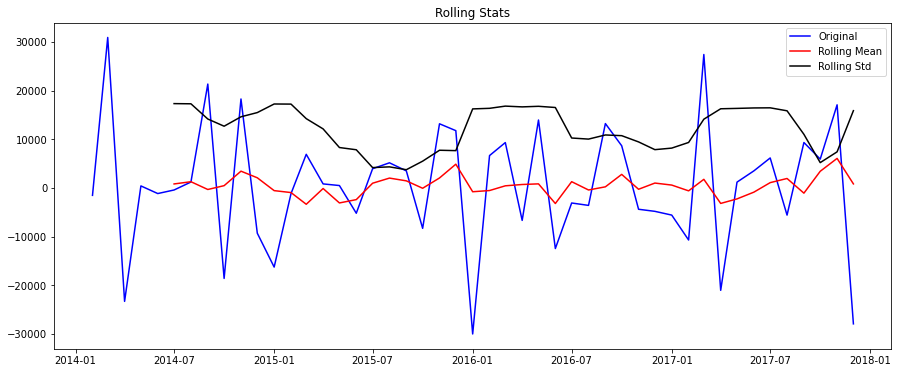

ADF Statistics: -4.45211223984516
p-value: 0.00023976055145415612
Critical Values:
	1%: -3.626651907578875
	5%: -2.9459512825788754
	10%: -2.6116707716049383


In [17]:
check_stationarity(df_diff)

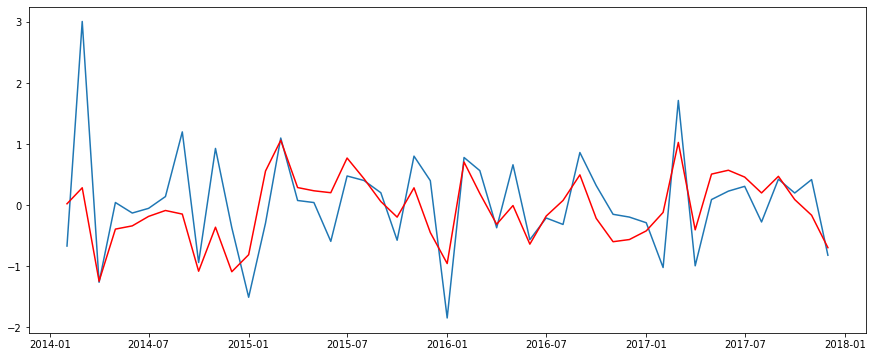

In [19]:
# df_diff might be the best bet we have at making the series stationary
# going to create and fit ARIMA model to our df_diff with AR of order 2, differencing order of  1, and MA of 2
decomposition = seasonal_decompose(df_log)
model = ARIMA(df_log, order = (2,1,2))
ARIMA_results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(ARIMA_results.fittedvalues, color='red')

In [24]:
predictions_ARIMA_diff = pd.Series(ARIMA_results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Total_Month_Sales'], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

predictions_ARIMA.head()

Order_Date
2014-01-01     3143.290000
2014-02-01     1644.568653
2014-03-01    44156.365540
2014-04-01     3594.370179
2014-05-01     2534.916648
dtype: float64

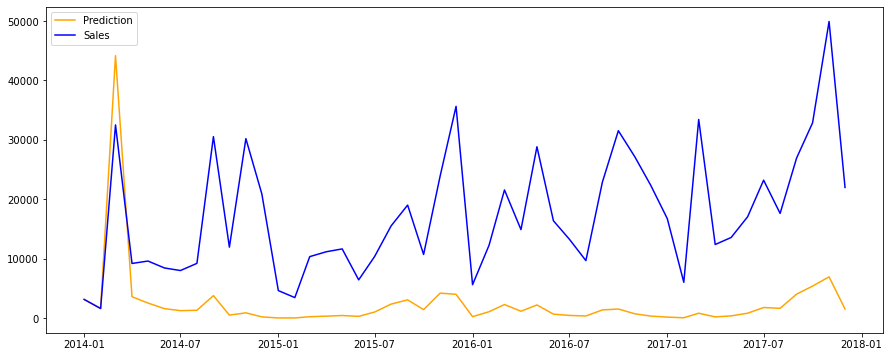

In [25]:
plt.plot(predictions_ARIMA, label='Prediction', color='Orange')
plt.plot(new_df['Total_Month_Sales'], label='Sales', color ='Blue')
plt.legend(loc='best')
plt.show()

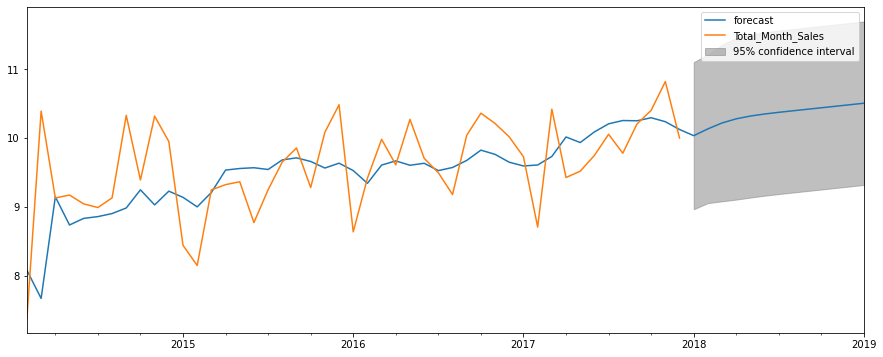

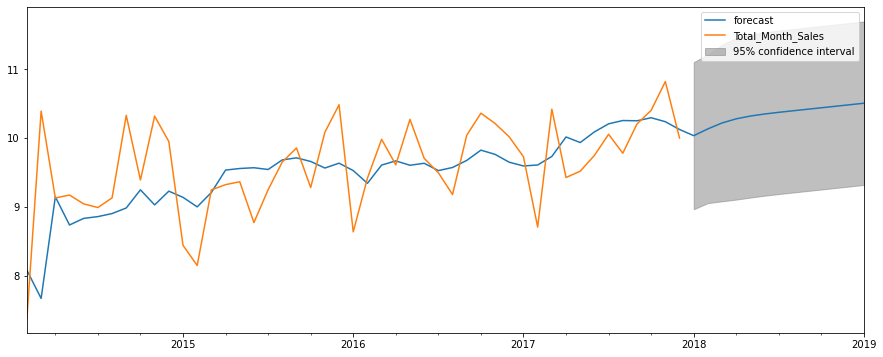

In [27]:
ARIMA_results.plot_predict(1,60)

In [ ]:
# I would love to know how to get exact values for the above graph ^
# i.e. what the forecasted sales on a particular date in the future